# A PINN Tutorial .ipynb Script

## Primer on Machine Learning

In much of today’s research on flow analysis, it has been traditionally based on physical theorems such as the Navier-Stokes equation. Computational fluid dynamics (CFD) simulations rely on these set of governing equations: mass, momentum, and continuity equations to provide a solution for the respective flow in question. With the recent advances in computing power and the increasing interest in Artificial Intelligence (AI), the marriage of these two has led to the influx of Machine Learning (ML) assisted CFD, which in theory aims to cut down on the computational resources normally required in a traditional CFD simulation. The aim of this short tutorial is for users who are new to deep neural networks.

By the end of this tutorial, users should be able to:
* Create a deep neural network architecture using TensorFlow Keras sequential layers.
* Train a simple deep neural network to generate predictions.
* Train a physics informed neural network.
* Understand the role of optimizers and activation functions.

## Deep Neural Network (Multi-layer perceptron)

### Problem 1

What is the ’MSE’ for a typical neural network? Express it in terms of known input ($X_{known}$), known output ($Y_{known}$) and predicted output ($Y_{predicted}$).

### Solution:

MSE stands for Mean Squared Error, and it is a common loss function used in various machine learning tasks, including training neural networks. It measures the average squared difference between the predicted output ($Y_{predicted}$) and the known output ($Y_{known}$) over a set of known input samples ($X_{known}$). The formula for calculating MSE is as follows:

$$MSE = \frac{\sum_{i=0}^{N=\text{len}(X_{known})}{(Y^{i}_{known} - Y^{i}_{predicted})^{2}}}{\text{len}(X_{known})}$$

In other words, for each known input-output pair, you calculate the squared difference between the predicted output and the known output. Then you take the average of all these squared differences to get the Mean Squared Error. 

The MSE is a crucial metric during neural network training. The goal is to minimize the MSE, which corresponds to reducing the average squared difference between predicted and actual outputs. By doing so, the neural network learns to approximate the underlying relationship between the inputs and outputs more accurately. Minimizing the MSE is achieved through optimization algorithms like Gradient Descent, which iteratively adjusts the neural network's parameters (weights and biases) to find the values that yield the lowest MSE. This process continues until the model converges to a solution where further adjustments to the parameters no longer lead to significant reductions in the MSE.

In summary, the Mean Squared Error quantifies the average squared discrepancy between predicted and actual outputs in a neural network. Its minimization is crucial for training accurate regression models, as it ensures the neural network effectively captures the underlying patterns and relationships within the data.

### Problem 2

Using TensorFlow 2.0 and Sequential Layers, create a deep neural network with the parameters below:
* Hidden layers: 3, 5, 7
* Number of Neurons: 50
* Number of epochs: 3000
* Activation function: Tanh

This deep neural network should be able to accept 2 inputs and 2 outputs. Train the model with the respective number of hidden layers using the ADAM optimizer and ’MSE’ as the loss function. Plot the prediction generated from each respective model using matplotlib. What differences do you notice in terms of loss values and the regions of high losses?

### Problem 3

Based on the same training parameters and neural network above, train the model with the parameters below:
* Hidden layers: 3
* Number of Neurons: 50
* Number of epochs: 3000
* Activation function: Tanh, Sigmoid, ReLU, SoftMax

Do the same as in Problem 2. Again, what differences do you notice in terms of loss values and the regions of high losses?

### Solution:

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

print(f"TensorFlow Version: {tf.__version__}")

plt.rcParams["figure.figsize"] = [24,8]

tf.random.set_seed(123456789)
np.random.seed(123456789)

# Solution

# Define a function to build the custom TensorFlow model
def build_model(numLayers: int, numNeurons: int, activationFunction: str):
    """
    Build a custom TensorFlow model with the specified number of layers, neurons, and activation function.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(numNeurons, activation=activationFunction, input_shape=(2,)))
    for _ in range(numLayers - 1):
        model.add(tf.keras.layers.Dense(numNeurons, activation=activationFunction))
    model.add(tf.keras.layers.Dense(2))  # Two outputs (Y1 and Y2)
    return model

# Load the dataset
dataset = pd.read_csv('./for_tim_DNN.csv').to_numpy()
np.random.shuffle(dataset)

trainDataset = dataset[0:int(8 * len(dataset) / 9), :]
np.savetxt('./NNTutorial/NNTrainDataset.csv', trainDataset, delimiter=',', fmt='%s')
testDataset = dataset[int(8 * len(dataset) / 9):, :]

# Split the dataset into training and testing
trainXDataset = dataset[0:int(0.85*len(dataset)), :2]
trainYDataset = dataset[0:int(0.85*len(dataset)), 2:]
testXDataset = dataset[int(0.85*len(dataset)):, :2]
testYDataset = dataset[int(0.85*len(dataset)):, 2:]

# Build a simple TensorFlow model using custom parameters
model = build_model(numLayers=3, # 3, 5, 7
                    numNeurons=50,
                    activationFunction='tanh') # 'tanh', 'relu', 'sigmoid', 'softmax'

# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model on the training data
model.fit(trainXDataset, trainYDataset, epochs=3000, batch_size=32)

# Evaluate the model on the testing data
testLoss = model.evaluate(testXDataset, testYDataset)
print(f"Test Loss: {testLoss}")

# Make predictions on the testing data
predictYModel = model.predict(testXDataset)
predictDataset = np.concatenate((testXDataset, predictYModel), axis=1)
np.savetxt('./NNTutorial/NNPredictDataset.csv', predictDataset, delimiter=',', fmt='%s')

# Sort the data based on x coordinate (you can also use y coordinate if it fits your data better)
sortIndices = np.argsort(testXDataset[:, 0])
x_CoordsSorted = testXDataset[sortIndices, 0]
y_CoordsSorted = testXDataset[sortIndices, 1]
u_VelocitiesSortedTest = testYDataset[sortIndices, 0]
v_VelocitiesSortedTest = testYDataset[sortIndices, 1]
u_VelocitiesSortedModel = predictYModel[sortIndices, 0]
v_VelocitiesSortedModel = predictYModel[sortIndices, 1]

# Create a grid using the sorted x and y coordinates
gridResolution = 1000  # Adjust the resolution based on your data
xCoordsSortedArray = np.linspace(x_CoordsSorted.min(), x_CoordsSorted.max(), gridResolution)
yCoordsSortedArray = np.linspace(y_CoordsSorted.min(), y_CoordsSorted.max(), gridResolution)
xCoordsSortedGrid, yCoordsSortedGrid = np.meshgrid(xCoordsSortedArray, yCoordsSortedArray)

# Interpolate the velocity components on the grid
u_VelocitiesTrain = griddata((x_CoordsSorted, y_CoordsSorted), u_VelocitiesSortedTest, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
v_VelocitiesTrain = griddata((x_CoordsSorted, y_CoordsSorted), v_VelocitiesSortedTest, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
u_VelocitiesModel = griddata((x_CoordsSorted, y_CoordsSorted), u_VelocitiesSortedModel, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
v_VelocitiesModel = griddata((x_CoordsSorted, y_CoordsSorted), v_VelocitiesSortedModel, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')

# absoluteDifference = np.sqrt((u_VelocitiesTrain - u_VelocitiesModel)**2 + (v_VelocitiesTrain - v_VelocitiesModel)**2)
absoluteDifference = abs(np.sqrt((u_VelocitiesTrain)**2 + (v_VelocitiesTrain**2)) - np.sqrt((u_VelocitiesModel)**2 + (v_VelocitiesModel**2)))

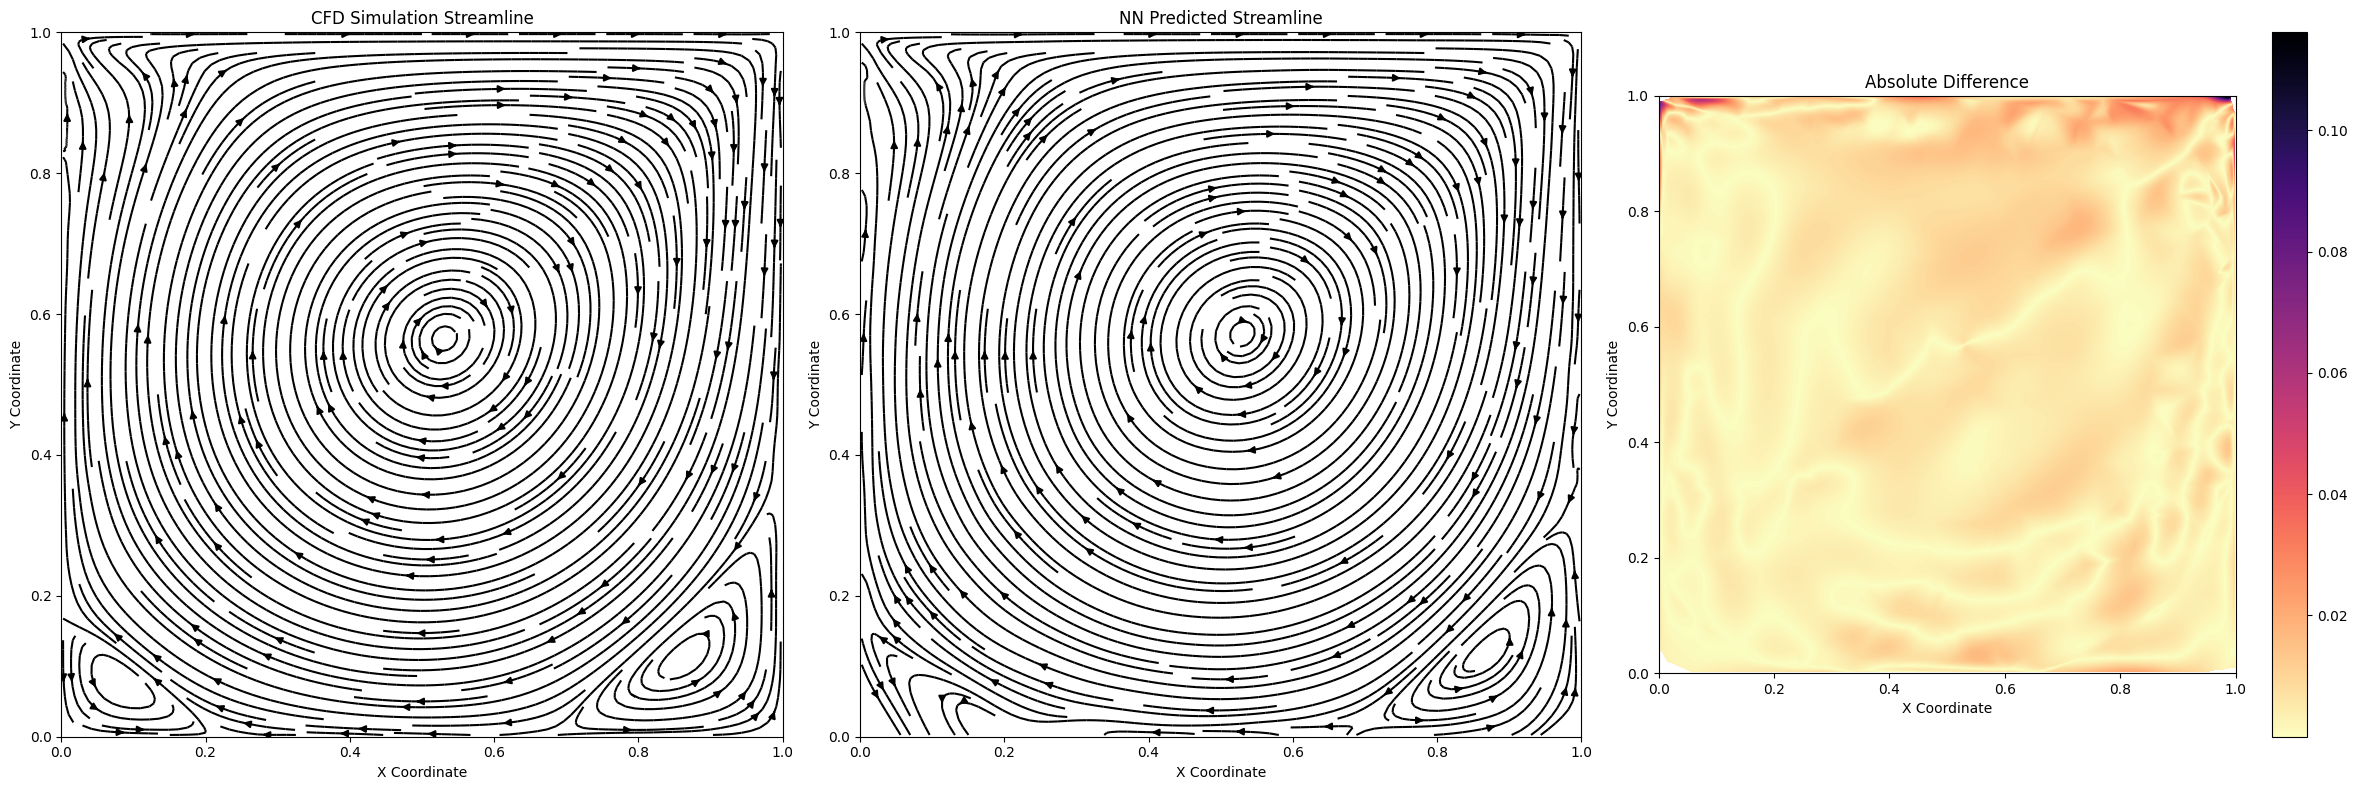

In [2]:
# Plot the streamline plots
plt.subplot(1, 3, 1)
plt.streamplot(xCoordsSortedGrid, yCoordsSortedGrid, u_VelocitiesTrain, v_VelocitiesTrain, density=2.5, color='black') 
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('CFD Simulation Streamline')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)

plt.subplot(1, 3, 2)
plt.streamplot(xCoordsSortedGrid, yCoordsSortedGrid, u_VelocitiesModel, v_VelocitiesModel, density=2.5, color='black')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NN Predicted Streamline')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)

plt.subplot(1, 3, 3)
plt.imshow(absoluteDifference, cmap='magma_r', origin='lower', extent=[xCoordsSortedGrid.min(), xCoordsSortedGrid.max(), yCoordsSortedGrid.min(), yCoordsSortedGrid.max()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Absolute Difference')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)
plt.colorbar()

plt.tight_layout()
plt.savefig('./NNTutorial/NNPlots.png', dpi=300)
plt.show()

## Physics Informed Neural Network (PINN)

The example used here is a classic 2-dimensional flow problem used widely in fluid dynamics. This is a good base to start off with if one wanted to understand the underlying principles of an NN or PINN. The governing equations for this flow is the incompressible Navier-Stokes equation as seen below:

$$\frac{du^{*}}{dt^{*}} + u^{*}\cdot u^{*} \nabla^{*} p^{*} + \frac{1}{Re}\nabla^{*^{2}}u^{*} + \frac{1}{Fr^{2}}\hat{g}u^{*}\cdot \nabla^{*} = 0 \quad (1)$$

Since our analysis is only limited to the steady-state regime of lid-driven cavity,
the time derivative vanishes. Furthermore, we consider a fluid in which inertial
forces are of a much greater order than gravitational forces. This allows us to
ignore the term with Fr. In other words, this steady state flow regime is purely
governed by the Reynolds Number:

$$Re  =\frac{UL}{\nu} \quad (2)$$

To further simplify the model, the governing equations are normalised by setting
$U = 1$ and $\rho = 1$. We will get the final equations seen below:

$$\nabla \cdot u = 0 \quad (3)$$

$$u \cdot \nabla u = -\nabla p + \frac{1}{Re}\nabla^{2}u \quad (4)$$

Equation $(3)$ which is the continuity equation becomes

$$\frac{du}{dx} + \frac{dv}{dy} = 0 \quad (5)$$

while equation $(4)$ which is the momentum equation can be split into its horizontal and vertical component. It becomes

$$u \cdot \frac{du}{dx} + v \cdot \frac{du}{dy} = -\frac{dp}{dx} + \frac{1}{Re}\left( \frac{d^{2}u}{dx^{2}} + \frac{d^{2}u}{dy^{2}} \right) \quad (6)$$

$$u \cdot \frac{dv}{dx} + v \cdot \frac{dv}{dy} = -\frac{dp}{dy} + \frac{1}{Re}\left( \frac{d^{2}v}{dx^{2}} + \frac{d^{2}v}{dy^{2}} \right) \quad (7)$$

In our case, our $X_{known}$ is the $(x,y)$ coordinates. both $x$ and $y$ are columns of values each. $Y_{known}$ is the vertical and horizontal components of velocity $(u,v)$. The shape/dimension of $(u,v)$ is the same as $(x,y)$.

### Problem 4

Create a deep neural network with the parameters below:
* Hidden layers: 5
* Number of Neurons: 50
* Number of epochs: 3000
* Activation function: Tanh

The challenge here is to incorporate the Physics constraint together with the loss function. How can we do that? Hint: Create a custom loss function; GradientTape() will be used somehow.

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

print(f"TensorFlow Version: {tf.__version__}")

plt.rcParams["figure.figsize"] = [24,8]

tf.random.set_seed(123456789)
np.random.seed(123456789)

# Solution

# Define a function to build the custom TensorFlow model
def build_model(numLayers: int, numNeurons: int, activationFunction: str):
    """
    Build a custom TensorFlow model with the specified number of layers, neurons, and activation function.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(numNeurons, activation=activationFunction, input_shape=(2,)))
    for _ in range(numLayers - 1):
        model.add(tf.keras.layers.Dense(numNeurons, activation=activationFunction))
    model.add(tf.keras.layers.Dense(2))  # Two outputs (Y1 and Y2)
    return model

# Define a function to compute the loss with the continuity and incompressible Navier-Stokes equations
def compute_loss(model, X, Y):
    """
    Compute the loss of the model using the continuity and incompressible Navier-Stokes equations.
    """
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        y_Predicted = model(X)
        Y1_u, Y2_v = tf.split(y_Predicted, 2, axis=1)
        Y1_u_dx = tape.gradient(Y1_u, X)[:, 0]
        Y2_v_dy = tape.gradient(Y2_v, X)[:, 1]
    continuityLoss = tf.reduce_mean(tf.square(Y1_u_dx + Y2_v_dy))
    velocityLoss = tf.reduce_mean(tf.square(y_Predicted - Y))
    totalLoss = continuityLoss + velocityLoss
    return totalLoss

# Load the dataset
dataset = pd.read_csv('./for_tim_DNN.csv').to_numpy()
np.random.shuffle(dataset)

trainDataset = dataset[0:int(8 * len(dataset) / 9), :]
np.savetxt('./PINNTutorial/PINNTrainDataset.csv', trainDataset, delimiter=',', fmt='%s')
testDataset = dataset[int(8 * len(dataset) / 9):, :]

# Split the dataset into training and testing
trainXDataset = dataset[0:int(0.85*len(dataset)):10, :2]
trainYDataset = dataset[0:int(0.85*len(dataset)):10, 2:]
testXDataset = dataset[int(0.85*len(dataset))::10, :2]
testYDataset = dataset[int(0.85*len(dataset))::10, 2:]

# Build a simple TensorFlow model using custom parameters
model = build_model(numLayers=3, # 3, 5, 7
                    numNeurons=50,
                    activationFunction='tanh') # 'tanh', 'relu', 'sigmoid', 'softmax'

# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model on the training data using GradientTape
numEpochs = 1000
batch_size = 32
for epoch in range(numEpochs):
    numBatches = len(trainXDataset) // batch_size
    for batch in range(numBatches):
        start = batch * batch_size
        end = (batch + 1) * batch_size
        trainXDatasetBatch = trainXDataset[start:end]
        trainYDatasetBatch = trainYDataset[start:end]
        with tf.GradientTape() as tape:
            loss = compute_loss(model, trainXDatasetBatch, trainYDatasetBatch)
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # print(f"Epoch: {epoch + 1} Batch: {batch + 1} Loss: {loss}")

# Evaluate the model on the testing data
testLoss = model.evaluate(testXDataset, testYDataset)
print(f"Test Loss: {testLoss}")

# Make predictions on the testing data
predictYModel = model.predict(testXDataset)
predictDataset = np.concatenate((testXDataset, predictYModel), axis=1)
np.savetxt('./PINNTutorial/PINNPredictDataset.csv', predictDataset, delimiter=',', fmt='%s')

# Sort the data based on x coordinate (you can also use y coordinate if it fits your data better)
sortIndices = np.argsort(testXDataset[:, 0])
x_CoordsSorted = testXDataset[sortIndices, 0]
y_CoordsSorted = testXDataset[sortIndices, 1]
u_VelocitiesSortedTest = testYDataset[sortIndices, 0]
v_VelocitiesSortedTest = testYDataset[sortIndices, 1]
u_VelocitiesSortedModel = predictYModel[sortIndices, 0]
v_VelocitiesSortedModel = predictYModel[sortIndices, 1]

# Create a grid using the sorted x and y coordinates
gridResolution = 1000  # Adjust the resolution based on your data
xCoordsSortedArray = np.linspace(x_CoordsSorted.min(), x_CoordsSorted.max(), gridResolution)
yCoordsSortedArray = np.linspace(y_CoordsSorted.min(), y_CoordsSorted.max(), gridResolution)
xCoordsSortedGrid, yCoordsSortedGrid = np.meshgrid(xCoordsSortedArray, yCoordsSortedArray)

# Interpolate the velocity components on the grid
u_VelocitiesTrain = griddata((x_CoordsSorted, y_CoordsSorted), u_VelocitiesSortedTest, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
v_VelocitiesTrain = griddata((x_CoordsSorted, y_CoordsSorted), v_VelocitiesSortedTest, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
u_VelocitiesModel = griddata((x_CoordsSorted, y_CoordsSorted), u_VelocitiesSortedModel, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')
v_VelocitiesModel = griddata((x_CoordsSorted, y_CoordsSorted), v_VelocitiesSortedModel, (xCoordsSortedGrid, yCoordsSortedGrid), method='cubic')

# absoluteDifference = np.sqrt((u_VelocitiesTrain - u_VelocitiesModel)**2 + (v_VelocitiesTrain - v_VelocitiesModel)**2)
absoluteDifference = abs(np.sqrt((u_VelocitiesTrain)**2 + (v_VelocitiesTrain**2)) - np.sqrt((u_VelocitiesModel)**2 + (v_VelocitiesModel**2)))

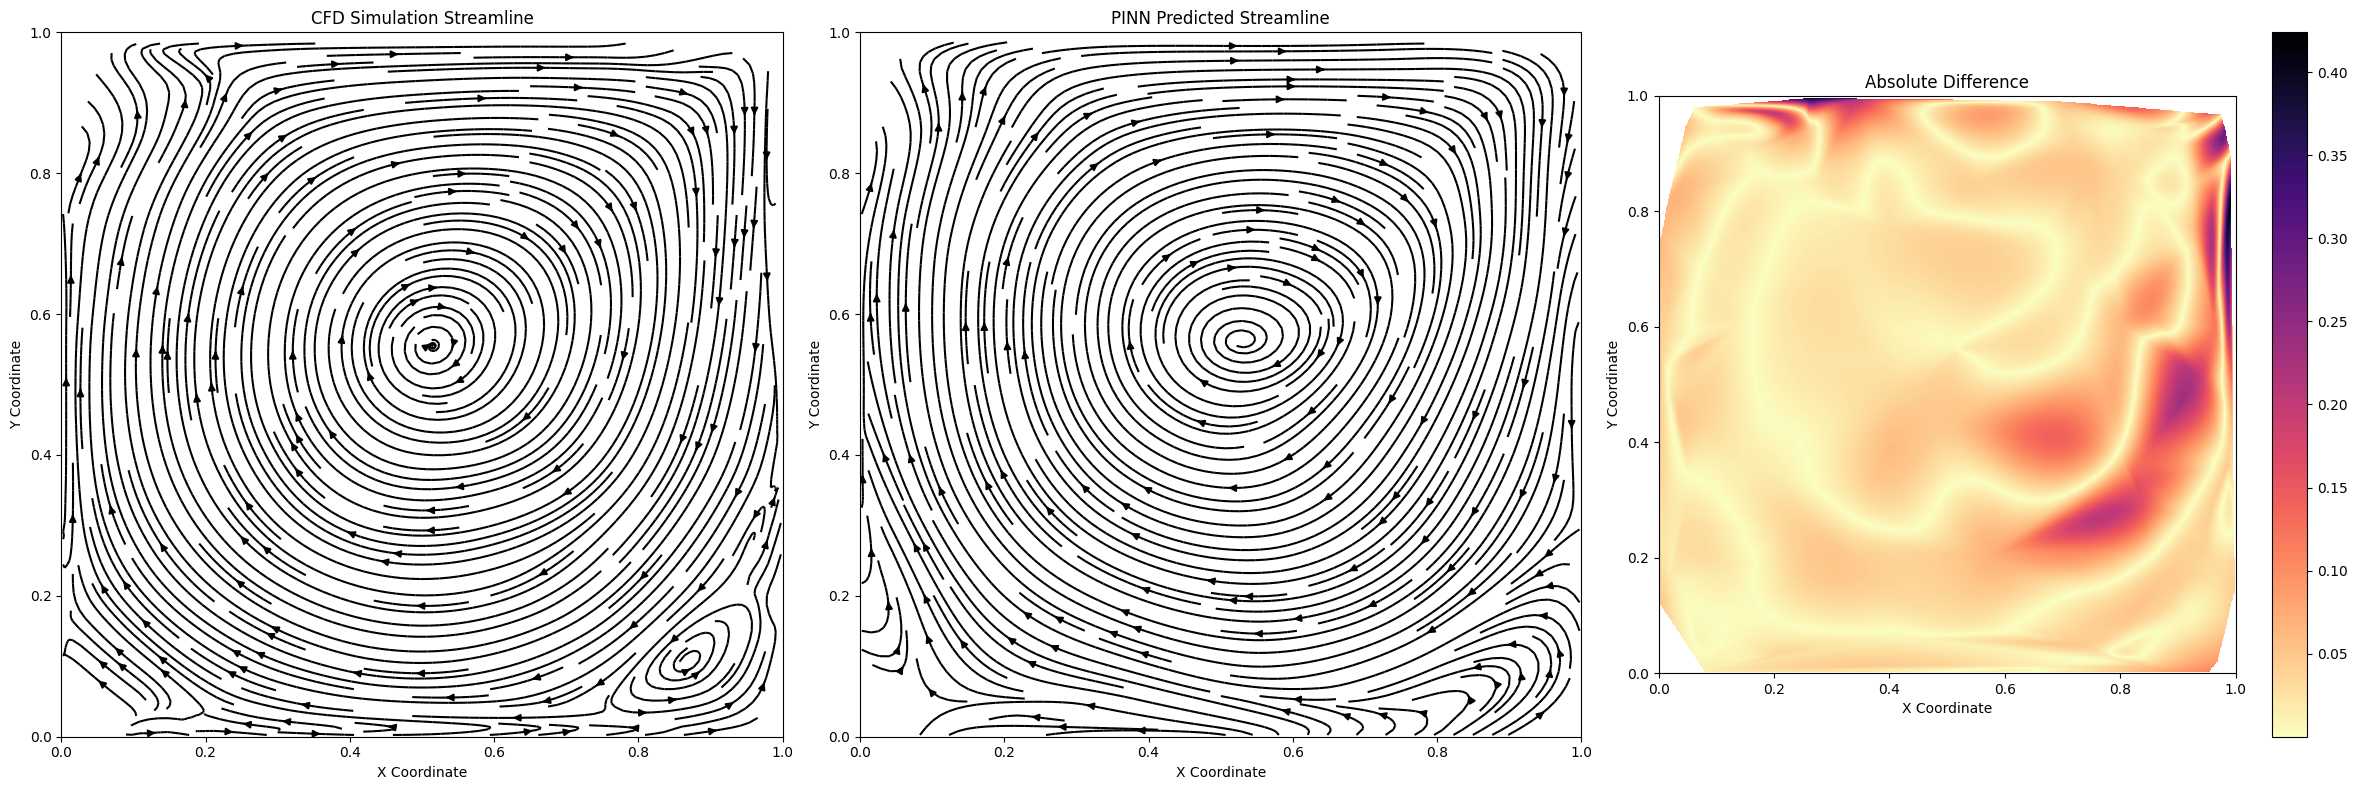

In [9]:
# Plot the streamline plots
plt.subplot(1, 3, 1)
plt.streamplot(xCoordsSortedGrid, yCoordsSortedGrid, u_VelocitiesTrain, v_VelocitiesTrain, density=2.5, color='black') 
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('CFD Simulation Streamline')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)

plt.subplot(1, 3, 2)
plt.streamplot(xCoordsSortedGrid, yCoordsSortedGrid, u_VelocitiesModel, v_VelocitiesModel, density=2.5, color='black')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('PINN Predicted Streamline')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)

plt.subplot(1, 3, 3)
plt.imshow(absoluteDifference, cmap='magma_r', origin='lower', extent=[xCoordsSortedGrid.min(), xCoordsSortedGrid.max(), yCoordsSortedGrid.min(), yCoordsSortedGrid.max()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Absolute Difference')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=1.0)
plt.colorbar()

plt.tight_layout()
plt.savefig('./PINNTutorial/PINNPlots.png', dpi=300)
plt.show()